# Tutored Challenge 2 - Web scraping 

In [1]:
# Date : 21/04/2022
# Author : S. Terki

### Workflow

<div>
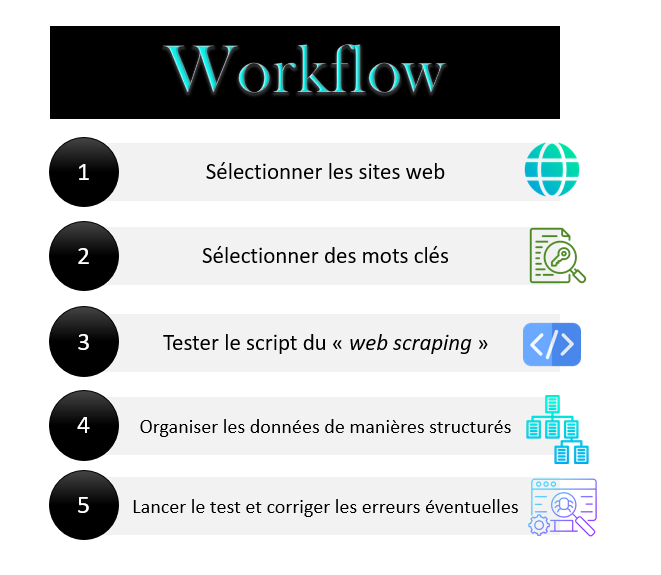
</div>

## Installation des modules

**Selenium** est un puissant outil de web-scraping qui a été initialement développé dans le but de tester automatiquement les sites Web. Selenium fonctionne en automatisant les navigateurs pour charger un site Web, récupérer son contenu et effectuer des actions. 
**Lxml** est une bibliothèque Python qui permet de manipuler facilement les fichiers XML et HTML, et peut également être utilisée pour le scraping web.

In [2]:
#installing selenium 
!pip install -U selenium
!pip install -U lxml
!pip install -U folium

Selenium nécessite cependant un logiciel d'intégration pour interagir avec un tiers, appelé **"WebDriver"** que l'on peut télecharger sur le site **https://sites.google.com/chromium.org/driver/.** Le fichier Zip obtenue doit être extrait et le fichier "Chromedriver.exe" placé dans le dossier contenant le notebook. Ce WebDriver correspond à la dernière version de *Google chrome (v.99)*

### Web scraping 

In [3]:
# import libraries for web scraping
from bs4 import BeautifulSoup
from selenium import webdriver
import json
import requests

#import classic librairires
import re
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from time import sleep
from random import randint
import warnings

##### Récupérer listes de sites web du site Crater & sur le navigateur Google à l'aide de mots clés établis

In [4]:
url = 'https://crater.resiliencealimentaire.org/diagnostic.html?idTerritoire=D-63'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')

for link in soup.find_all('a'):
    link = str(link.get('href'))    
    if re.search("^https(.*)", link):
        print(link)    

https://resiliencealimentaire.org/formulaire-crater/


En recherchant les partenaires présents dans ces sites, on décide de *scraper* ces liens:
* https://www.acheteralasource.com/producteurs-en-france/all/departement/63
* https://terredeliens.org/auvergne.html
* https://denosfermes63.puy-de-dome.fr/accueil.html
* https://granvillage.com/d/63-puy-de-dome

##### Rechercher des producteurs alimentaires du Puy-de-dôme 

In [5]:
##################### acheteralasource ########################

# Config
start_time = time.time()
warnings.filterwarnings('ignore')
print("======== Starting Webscraping =======")

# For several pages
print("Webscraping acheteralasource...")
pages = np.arange(9) # until page 8 
results = []

for page in pages:
    page = "https://www.acheteralasource.com/producteurs-en-france/all/departement/63/page/" + str(page) 
    driver = webdriver.Chrome()
    driver.get(page) 
    # avoid beeing blocked by IP
    sleep(randint(2,10)) 
    # scraping the web page
    soup = BeautifulSoup(driver.page_source, 'lxml')
    
    # finding the tag with the script where info are
    all_scripts = soup.find_all('script')[34].string 
    jsonStr = re.match('.*__APOLLO_STATE__=({.*})' , all_scripts).group(1)
    #Loading and formating webpage to dict using json
    jsonData = json.loads(jsonStr)
    
    for k, v in jsonData.items():
        if 'Producer' in k: # looking for EsProducerOutput:xxx containing the info we want
            try :
                categories = v.pop('categories')['json']
            except TypeError:
                categories = '-'
            coordinates = v.pop('addressCoordinates')['json']   
            # Copy dict
            alpha = v.copy()
            alpha.update({'Production':categories,
                  'addressCoordinates':coordinates})
        
            results.append(alpha)
    driver.close()
print("Done\n")

################### Terredeliens #####################
print("Webscraping TerredeLiens...")
urls = "https://terredeliens.org//auvergne.html"
reqs = requests.get(urls)
soup = BeautifulSoup(reqs.text, 'lxml')
full_lines = soup.find_all("div", {"class": "flocalisation details"})

#Getting company names
comp_name=[]
comp_name_list = soup.find_all('h3')
for company in comp_name_list:
    if company.find('a'):
        comp_name.append(company.find('a')['href'])
        comp_name.append(company.find('a').text)
        
#delete the company containing .html and removing \n & \t
comp_name = [ x for x in comp_name if ".html" not in x ]
comp_name = [s.replace('\n', '').replace('\t', "") for s in comp_name]

#create a list where info are stocked
linesArr = []
for line in full_lines:
     linesArr.append(line.get_text())
        
#Create a list where company name are
i=0
res = {}
for company, info in zip(comp_name, linesArr):
    info = str(linesArr[i:i+3])
    res[company]= info 
    i=i+3
print("Done\n")

###################### granvillage ######################## 
print("Webscraping granvillage...")
bs4tostr=[]
company_name_list = []
producteur_list = []
address_list = []

pages = np.arange(1,14) # until page 13

for urls in pages :
    urls = "https://granvillage.com/d/63-puy-de-dome/" + str(urls) 
    reqs = requests.get(urls)
    soup = BeautifulSoup(reqs.text, 'lxml')
    # avoid beeing blocked by IP
    sleep(randint(2,10)) 
    pages = pages + 1
    
    #converting bs4.element to string
    soup_h4 = soup.find_all('h4')
    for elements in soup_h4: 
        bs4tostr.append(str(elements))
        
    #Getting company name
    for company in bs4tostr:
        pattern = re.search('>+(.*)<', company)
        name = pattern.group(1)
        company_name_list.append(name)
    
    # producteurs function
    producteur_lines = soup.find_all("div",{"class":"d-flex flex-wrap m-n2"})
    for line in producteur_lines:
        producteur = line.get_text().replace('\n','')
        producteur_list.append(producteur)
        
    # adress list
    address_lines = soup.find_all("span", {"class":"small"})
    for line in address_lines:
        elem = line.get_text()
        elem = elem.replace("Contacter","").replace("\n","")\
        .replace("                ","").replace("     ","").replace("    ","").replace("   ","") #cleaning string
        address_list.append(elem)
print("Done\n")

################## denosfermes63 ####################### 
print("Webscraping denosfermes63...")
name = []
address = []
coordinates = []
production = []
presentation = []

pages = np.arange(0,24) # until page 23 (24)
for url in pages :
    urls = "https://denosfermes63.puy-de-dome.fr/producteurs/mode-vu/LIST.html?tx_solr%5Banchor%5D=1&tx_solr%5Bpage%5D=" + str(url)
    reqs = requests.get(urls)
    soup = BeautifulSoup(reqs.text, 'lxml')
    
    #take all href to extract all the info for each producteurs
    page_prod = []
    for link in soup.findAll('a', {'class': 'popin-iframe'}):
        try:
            page_prod.append("https://denosfermes63.puy-de-dome.fr" + str(link['href']))
        except KeyError:
            pass 

    #appending info to list
    for link in page_prod:
        reqs = requests.get(link)
        soup_prod = BeautifulSoup(reqs.text, 'html.parser')
    
        #getting presentation info
        pres = soup_prod.find("div",{"class":"desc-annu"})
        if pres:
            for x in pres:
                presentation.append(x)
        else:
            presentation.append("No infos")

    
        #getting production info
        prod = soup_prod.find("span",{"class":"nature"})
        if prod:
            for x in prod:
                production.append(x)
        else:
            production.append("No infos")
    
       #getting name
        name.append(soup_prod('meta',{'name':"twitter:title"})[0]['content'])
    
        #getting coordinates
        coordinates.append(soup_prod.find_all('meta',{"name":"geo.position"})[0]['content'])
    
        #getting addresses
        for x in soup_prod.find_all("div",{"class":"annuaire--address-text"}):
            address.append(x.find('p').text.replace("\r","").replace('\n',", ")) 
print("Done")
print("Web scraping done in %s seconds !" % (time.time() - start_time))

======== Starting Webscraping =======
Webscraping acheteralasource...
Done

Webscraping TerredeLiens...
Done

Webscraping granvillage...
Done

Webscraping denosfermes63...
Done
Web scraping done in 465.82995891571045 seconds !


#### Organisation des données

In [8]:
print("Organizing data...")

#========================= acheteràlasource =================================#
# Converting to dataframe
source_df = pd.DataFrame(results)
# Split address coordinates to latitude and longitude
source_df['latitude'], source_df['longitude'] = zip(*list(source_df['addressCoordinates'].values)) 

# Cleaning df
source_df = source_df.drop(["id", "__typename", "photoProducerUrl", "addressCoordinates"], axis=1)
source_df.Production = source_df['Production'].str.get(0) #no brackets
source_df.drop_duplicates(keep = 'first', inplace=True) #no duplicates

# Keeping only those who are in Puy-de-dôme (63)
source_df_63 = source_df.loc[source_df['addressPostalCode'].str.startswith("63")]
source_df_63 = source_df_63.sort_values(by=['companyName'])

#concatenate city and postal code columns
source_df_63["Localisation"] = source_df_63["addressCity"] + " " + source_df_63["addressPostalCode"].astype(str)
source_df_63 = source_df_63.drop(columns=["addressCity","addressPostalCode"])

#========================= terredeliens ========================================#
# Cleaning df
#Convert terre_df
terr_df = pd.DataFrame(list(res.items()), columns = ['companyName','Info']) 
terr_df['Info'] = terr_df['Info'].str.strip("[]") #delete brackets 

#spliting list values and removing non necesseray columns
terr_df[['null','Localisation','null','presentation','null', 'Production', 'null']] = terr_df['Info'].str.split("'",expand=True)
terr_df = terr_df.drop(["Info","null"], axis=1)
terr_df = terr_df.replace(['^(.*): '], [''], regex=True) #deleting patrimoine, productions, localisation

#garder ceux du puy-de-dôme
terr_df_63 = terr_df[terr_df['Localisation'].str.contains("Puy-de-Dôme")]

# ajouter les colonnes lat et long vides
terr_df_63['latitude'] = pd.Series(dtype='int')
terr_df_63['longitude'] = pd.Series(dtype='int')

#Calculate lat and long for terredelien_df63
import urllib.parse
for local in terr_df_63['Localisation']:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(local) +'?format=json'
    response = requests.get(url).json()
    terr_df_63['latitude'] = response[0]["lat"]
    terr_df_63['longitude'] = response[0]["lon"]
    
#===================== granvillage ========================== RIEN POUR LE PUY DE DOME #
#Deleting none elements in all lists
#address_list = [i for i in address_list if i]
#company_name_list = [i for i in company_name_list if i]

#associate infos
#granvillage_df = pd.DataFrame(np.column_stack([company_name_list, address_list, producteur_list]), 
#                                 columns=['companyName', 'addressCity', 'Production'])
#granvillage_df = granvillage_df.sort_values(by=['companyName'])

#granvillage_df_63 = granvillage_df[granvillage_df['addressCity'].str.contains("\(63\d+\)")]

#=================== denosfermes63 =====================================#
#cleaning list
clean_production=[]
for el in production:
    el = el.strip().replace("\n","").replace('                                                     ','') #long white space
    clean_production.append(el)
    
# #----------------------Ne lancer qu'une seule fois ce bloc------------------------------------------------
new_101 = ''.join([str(presentation[i]) for i in [101, 102, 103]]) #rattaché le numéro 102 presentation au 101
presentation[101] = str(new_101) # replace messy index
presentation = [j for i, j in enumerate(presentation) if i not in [102, 103]] #delete old index 102 & 103
#-------------------------------------------------------------------------------------------------

# #convert to df
df_denosfermes_63 = pd.DataFrame(np.column_stack([name, presentation, address, clean_production, coordinates]), 
                                 columns=['companyName', 'presentation', 'Localisation', 'Production', 'Coordinates'])

# Split address coordinates to latitude and longitude
df_denosfermes_63[['latitude','longitude']] = df_denosfermes_63['Coordinates'].str.split(";",expand=True)
df_denosfermes_63 = df_denosfermes_63.drop(["Coordinates"], axis=1)
df_denosfermes_63 = df_denosfermes_63.drop_duplicates()

#====================Checking and merging =====================#

# #checking if company in denosfermes are in acheteralasource
denosferme_63_nodup = df_denosfermes_63.assign(In_63=df_denosfermes_63.companyName.isin(source_df_63.companyName).astype(str))
denosferme_63_nodup = denosferme_63_nodup[denosferme_63_nodup['In_63'] == 'False'].drop(["In_63"], axis=1)

source_df_63_nodup = source_df_63.assign(In_63=source_df_63.companyName.isin(denosferme_63_nodup.companyName).astype(str))
source_df_63_nodup = source_df_63_nodup[source_df_63_nodup['In_63'] == 'False'].drop(["In_63"], axis=1)

# merging both dataframes (denosfermes + acheteralasource)
frames = [denosferme_63_nodup, source_df_63_nodup]
all_info_63_df = pd.concat(frames)#, keys=["denosfermes63", "acheteralasource"])

#comparing with terredelien
terredelien_63_nondup = terr_df_63.assign(In_63=terr_df_63.companyName.isin(all_info_63_df.companyName).astype(str))
terredelien_63_nondup = terredelien_63_nondup[terredelien_63_nondup['In_63'] == 'False'].drop(["In_63"], axis=1)

# merging all (denosfermes + acheteralasource + terredelien)
frames = [denosferme_63_nodup, source_df_63_nodup, terredelien_63_nondup]
all_info_63_df = pd.concat(frames)#, keys=["denosfermes63", "acheteralasource", "terredelien"])
display(all_info_63_df)
print("Done")

# ======================== Export to excel ==========================#
# determining the name of the file
#file_name = 'producteurs_63.xlsx'
  
# saving the excel
#all_info_63_df.to_excel(file_name)
#print('DataFrame is written to Excel File successfully.')

Organizing data...


,companyName,presentation,Localisation,Production,latitude,longitude
0,EI Pierre Galtier Maraichage,Producteur en vente directe de fruits et légum...,"Route de la Greleyre, 63940 Marsac-en-Livradois",Fruits et légumes- Fruits - Arboriculture- Pet...,45.495974,3.74568
1,AUVERGNE TRUITES,L'exploitation comporte une dizaine de bassins...,"Moulin Neuf, 63320 ST DIERY",Autres- Pisciculture,45.5319137873,3.02662208431
2,Arsène et Lilly,Jolis Baumes est une jeune savonnerie artisana...,"2 Rue du Moulin, 63260 Vensat",Autres- Divers,46.065537,3.154199
3,Association des producteurs de Fourmes Fermièr...,L'association a pour objectif de promouvoir et...,"10 route du Mont Dore, 63210 Rochefort-Montagne",Fromages et produits laitiers- Fromage de Vache,45.6848162,2.804789400000004
4,Au Jardin d'Eglantine,"Le jardin d'Eglantine est situé en Limagne, su...","3 rue des Jardins Buxerolles, 63720 Saint-Ignat",Autres- Plantes à Parfum Aromatiques et Médici...,45.91402799999999,3.287659899999994
...,...,...,...,...,...,...
1,Villevaud,80 ha,"Gerzat, Puy-de-Dôme","agriculture biologique.""",45.6689972,3.1091394
5,Ferme des Raux,"46,24 ha de terres et les bâtiments d’exploita...","Gerzat, Puy-de-Dôme","Céréales, volailles de chair",45.6689972,3.1091394
6,Les Cheires,6 ha de vergers et terres,"Saint-Amant-Tallende, Puy-de-Dôme (63)",Pommes de variétés diverses,45.6689972,3.1091394
10,Verger de l’Étoile,10 hectares,"Saint-Amant-Tallende, Puy-de-Dôme (63)","Pommes, cerises, pêches, prunes. Jus de pomme....",45.6689972,3.1091394


Done


### Analyse et Visualisation 

#### Organiser les catégories de production

In [9]:
#keep the high production products and replace names
all_info_63_df['prod_colors'] = all_info_63_df['Production'].str.extract('^([^-]*)', expand=False).str.strip()
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Vins et spiritueux','Vins')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Miel et produits de la ruche','Miel')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Volailles et lapins','Volailles')

#replace manually for last 5 rows
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('agriculture biologique."','')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Céréales, volailles de chair', 'Volailles')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Pommes de variétés diverses', 'Fruits')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Céréales, transformation en pain, poules pondeuses', '')
all_info_63_df['prod_colors'] = all_info_63_df['prod_colors'].str.replace('Pommes, cerises, pêches, prunes. Jus de pomme. Compote de pomme.','Fruits')

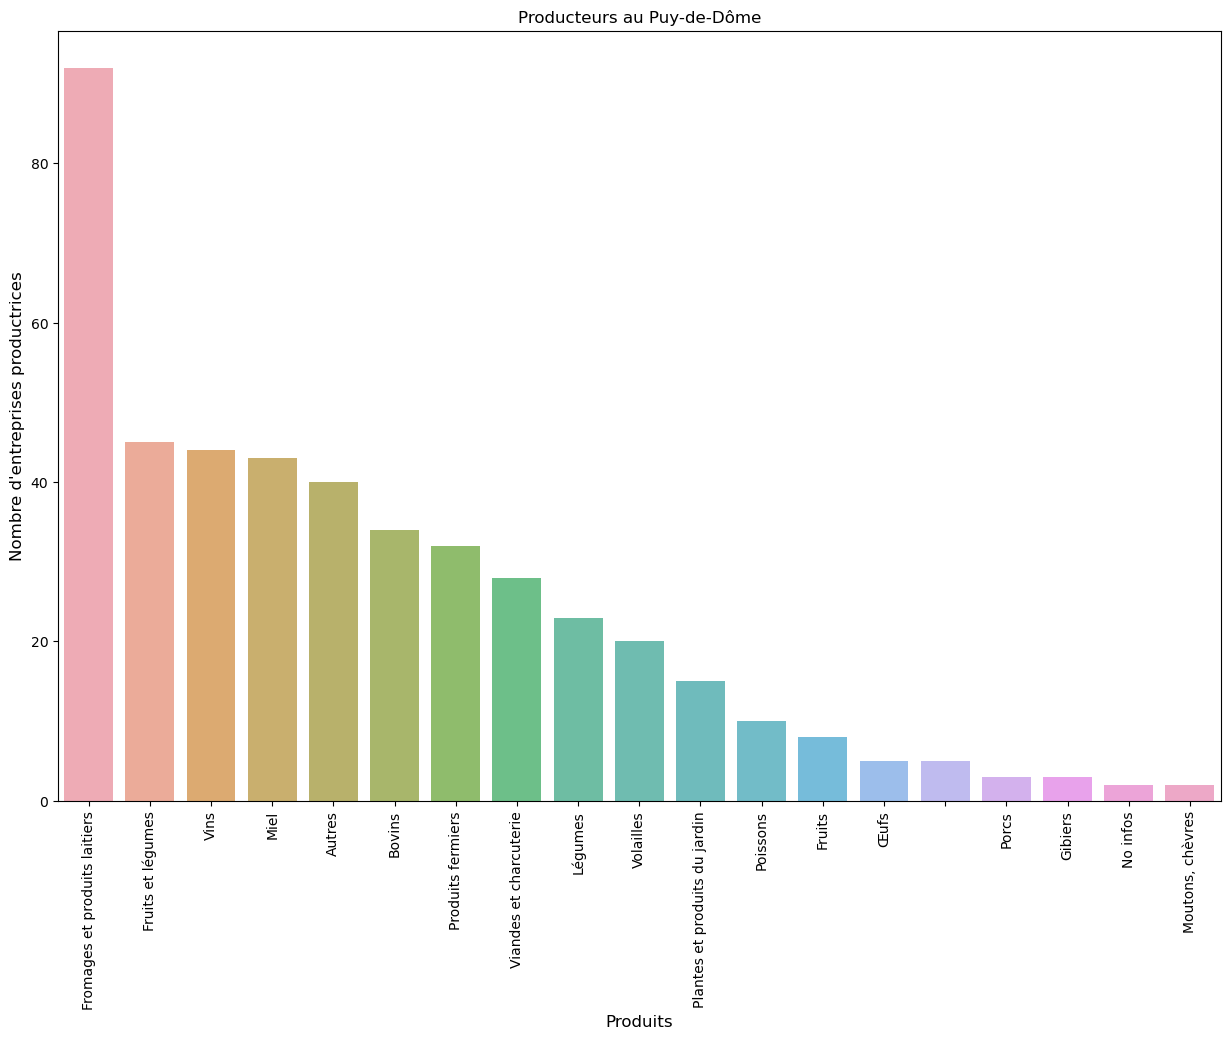

In [10]:
#Plotting categories
cat_count = all_info_63_df['prod_colors'].value_counts()
plt.figure(figsize=(15,10))
ax = sn.barplot(cat_count.index, cat_count.values, alpha=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title('Producteurs au Puy-de-Dôme')
plt.ylabel("Nombre d'entreprises productrices", fontsize=12)
plt.xlabel('Produits', fontsize=12)
plt.show()

##### Cartographie

In [11]:
#list of resumed products PROBLEMS WITH SOME COLORS
colors = {'Bovins' : 'red', 'Viandes et charcuterie' : 'red' ,'Poissons' : 'blue', 'Miel' : 'orange', 'Œufs' : 'beige',\
          'Vins' : 'lightred', 'Fromages et produits laitiers' : 'white', 'Fruits et légumes' : 'green', \
          'Autres' : 'gray', 'Porcs' : 'pink', 'Volailles' : "cadetblue", "No infos" : "black", "Produits fermiers" : "lightblue", \
         "Plantes et produits du jardin" : "darkgreen", "Gibiers" : "purple", "Légumes" : "Green", '':'gray', "Fruits" : "lightpink",\
         "Moutons, chèvres" : "white"}

In [12]:
# libraries
import folium
from pyensae.notebookhelper import folium_html_map
from IPython.display import HTML

# Keeping only necessary columns
all_info_63_location = all_info_63_df[['companyName','latitude','longitude','Production', 'prod_colors']]

#converting lati and long to float
lati = pd.to_numeric(all_info_63_location["latitude"], errors='coerce')
longi = pd.to_numeric(all_info_63_location["longitude"], errors='coerce')
all_info_63_location["LAT"] = lati
all_info_63_location["LONG"] = longi

#creating map zooming in clermont-ferrand
map = folium.Map([45.7797,3.08694], control_scale=True)

for index, location_info in all_info_63_location.iterrows():    
    folium.CircleMarker([location_info["latitude"], location_info["longitude"]], \
                                popup=location_info["companyName"] +"\n"+"--------"+"\n"+location_info["Production"],\
                                fill_color=colors[location_info['prod_colors']], color= colors[location_info['prod_colors']],\
                        opacity=1, fill_opacity=0.85).add_to(map)
#afficher map
map